In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    

In [2]:

!pip install setuptools --upgrade

!pip install git+https://github.com/CUQI-DTU/CUQIpy-FEniCS.git@sprint13_observation_bug#egg=CUQIpy-FEniCS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CUQI-DTU/CUQIpy-FEniCS.git (to revision sprint13_observation_bug) to /tmp/pip-install-_6xj8_y5/cuqipy-fenics_e5136d2328a64bc4abd6e1bf4787d638
  Running command git clone -q https://github.com/CUQI-DTU/CUQIpy-FEniCS.git /tmp/pip-install-_6xj8_y5/cuqipy-fenics_e5136d2328a64bc4abd6e1bf4787d638
  Running command git checkout -b sprint13_observation_bug --track origin/sprint13_observation_bug
  Switched to a new branch 'sprint13_observation_bug'
  Branch 'sprint13_observation_bug' set up to track remote branch 'sprint13_observation_bug' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for CUQIpy-FEniCS: filename=CUQIpy_FEniCS-0.1.1.post0.dev1-py3-none-any.whl si

In [3]:
pip install cuqipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install cuqipy_fenics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import dolfin as dl
import numpy as np
import cuqipy_fenics
import cuqi
import mshr
import matplotlib.pyplot as plt

In [11]:
#%% 1.1 Define domain and mesh
domain = mshr.Circle(dl.Point(0,0),1)
mesh = mshr.generate_mesh(domain, 20)

#%% 1.2 Define function spaces 
parameter_space = dl.FunctionSpace(mesh, "CG", 1)
solution_space = dl.FunctionSpace(mesh, "CG", 1)

#%% 1.3 Define boundary input as source term
class boundary_input(dl.UserExpression):
    def set_freq(self, freq=1.):
        self.freq = freq
    def eval(self, values, x, tag='sin'):
        theta = np.arctan2(x[1], x[0])
        values[0] = np.sin(self.freq*theta)

boundary = lambda x, on_boundary: on_boundary

FEM_el = solution_space.ufl_element()

bc_func = boundary_input(element=FEM_el)
bc_func.set_freq(freq=2.)

bc = dl.DirichletBC(solution_space, bc_func, boundary)

w = dl.Function(solution_space)
bc.apply(w.vector())

#%% 1.3.1 Defining zero boundary for the extended problem
u0 = dl.Constant('0.0')
zero_bc = dl.DirichletBC(solution_space, u0, boundary)

#%% 1.4 Define Poisson problem form
def form(kappa,u,v):
    return dl.inner( kappa*dl.grad(u), dl.grad(v) )*dl.dx + dl.inner( dl.grad(w), dl.grad(v) )*dl.dx

#%% 1.6 Define observation map (applied to the solution to generate the 
# observables)

#%% 1.6.1 extracting the index of boundary elements
dummy = dl.Function(solution_space)
dummy.vector().set_local( np.ones_like( dummy.vector().get_local() ) )
zero_bc.apply( dummy.vector() )
bnd_idx = np.argwhere( dummy.vector().get_local() == 0 ).flatten()

normal_vec = dl.FacetNormal( mesh )
tests = dl.TestFunction( solution_space )

def obs_func(kappa, u):
  obs_form = dl.inner( dl.grad(u + w), normal_vec )*tests*dl.ds

  obs = dl.assemble( obs_form )
  return obs.get_local()[bnd_idx]



#u = dl.TrialFunction(solution_space)
#v = dl.TestFunction(solution_space)

#A = dl.lhs(form(1,u,v))
#b = dl.rhs(form(1,u,v))

#solution = dl.Function(solution_space)
#dl.solve(A==b,solution,zero_bc)
#dl.plot(solution+ w)

#%% 2.1 Create the domain geometry
# 2.1.1 The space on which the Bayesian parameters are defined
fenics_continuous_geo = cuqipy_fenics.geometry.FEniCSContinuous(parameter_space)

# 2.1.2 The Matern fieled (maps i.i.d normal random vector of dimension `num_terms`
# to Matern field realization on `fenics_continuous_geo`)
matern_geo = cuqipy_fenics.geometry.MaternExpansion(fenics_continuous_geo, length_scale = .2, num_terms=64)

# 2.1.3 We create a map `heavy_map` to map the Matern field realization to two levels
# c_minus and c_plus 
c_minus = 1
c_plus = 10
def heavy_map(func):
    dofs = func.vector().get_local()
    updated_dofs = c_minus*0.5*(1 + np.sign(dofs)) + c_plus*0.5*(1 - np.sign(dofs))
    func.vector().set_local(updated_dofs)
    return func

# 2.1.4 Finally, we create the domain geometry which applies the
# map `heavy_map` on Matern realizations.
domain_geometry = cuqipy_fenics.geometry.FEniCSMappedGeometry(matern_geo, map = heavy_map)

#%% 2.2 Create the range geomtry 
range_geometry = cuqi.geometry.Continuous1D(94) 

#%% 2.3 Create CUQI PDE (which encapsulates the FEniCS formulation
# of the PDE)
PDE = cuqipy_fenics.pde.SteadyStateLinearFEniCSPDE( form, mesh, solution_space, parameter_space,zero_bc, observation_operator=obs_func)

#%% 2.4 Create CUQI model
model = cuqi.model.PDEModel(PDE,range_geometry,domain_geometry)

#%% 2.5 Create a prior
pr_mean = np.zeros(domain_geometry.par_dim)
prior = cuqi.distribution.GaussianCov(pr_mean, cov=np.eye(domain_geometry.par_dim), geometry= domain_geometry)

#%% 2.6 Define the exact solution
exactSolution = prior.sample()

#%% 2.7 Generate exact data 
b_exact = model(exactSolution)

#%% 2.8 Create the data distribution
SNR = 100
sigma = np.linalg.norm(b_exact)/SNR
sigma2 = sigma*sigma # variance of the observation Gaussian noise
data_distribution = cuqi.distribution.GaussianCov(model, sigma2*np.ones(range_geometry.par_dim), geometry=range_geometry)

#%% 2.9 Generate noisy data
data = data_distribution(x=exactSolution).sample()

#%% 2.10 Create the data distribution and the likelihood
likelihood = data_distribution.to_likelihood(data)

#%% 2.11 Create posterior
posterior = cuqi.distribution.Posterior(likelihood, prior)


 Sample 10000 / 10000

Average acceptance rate: 0.2786 MCMC scale: 0.03620744396918488 



/usr/local/lib/python3.7/dist-packages/cuqipy_fenics/geometry.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows,cols,subplot_id);


Selecting 5 randomly chosen variables
Selecting 5 randomly chosen variables


Text(0.5, 1.0, 'Credible interval')

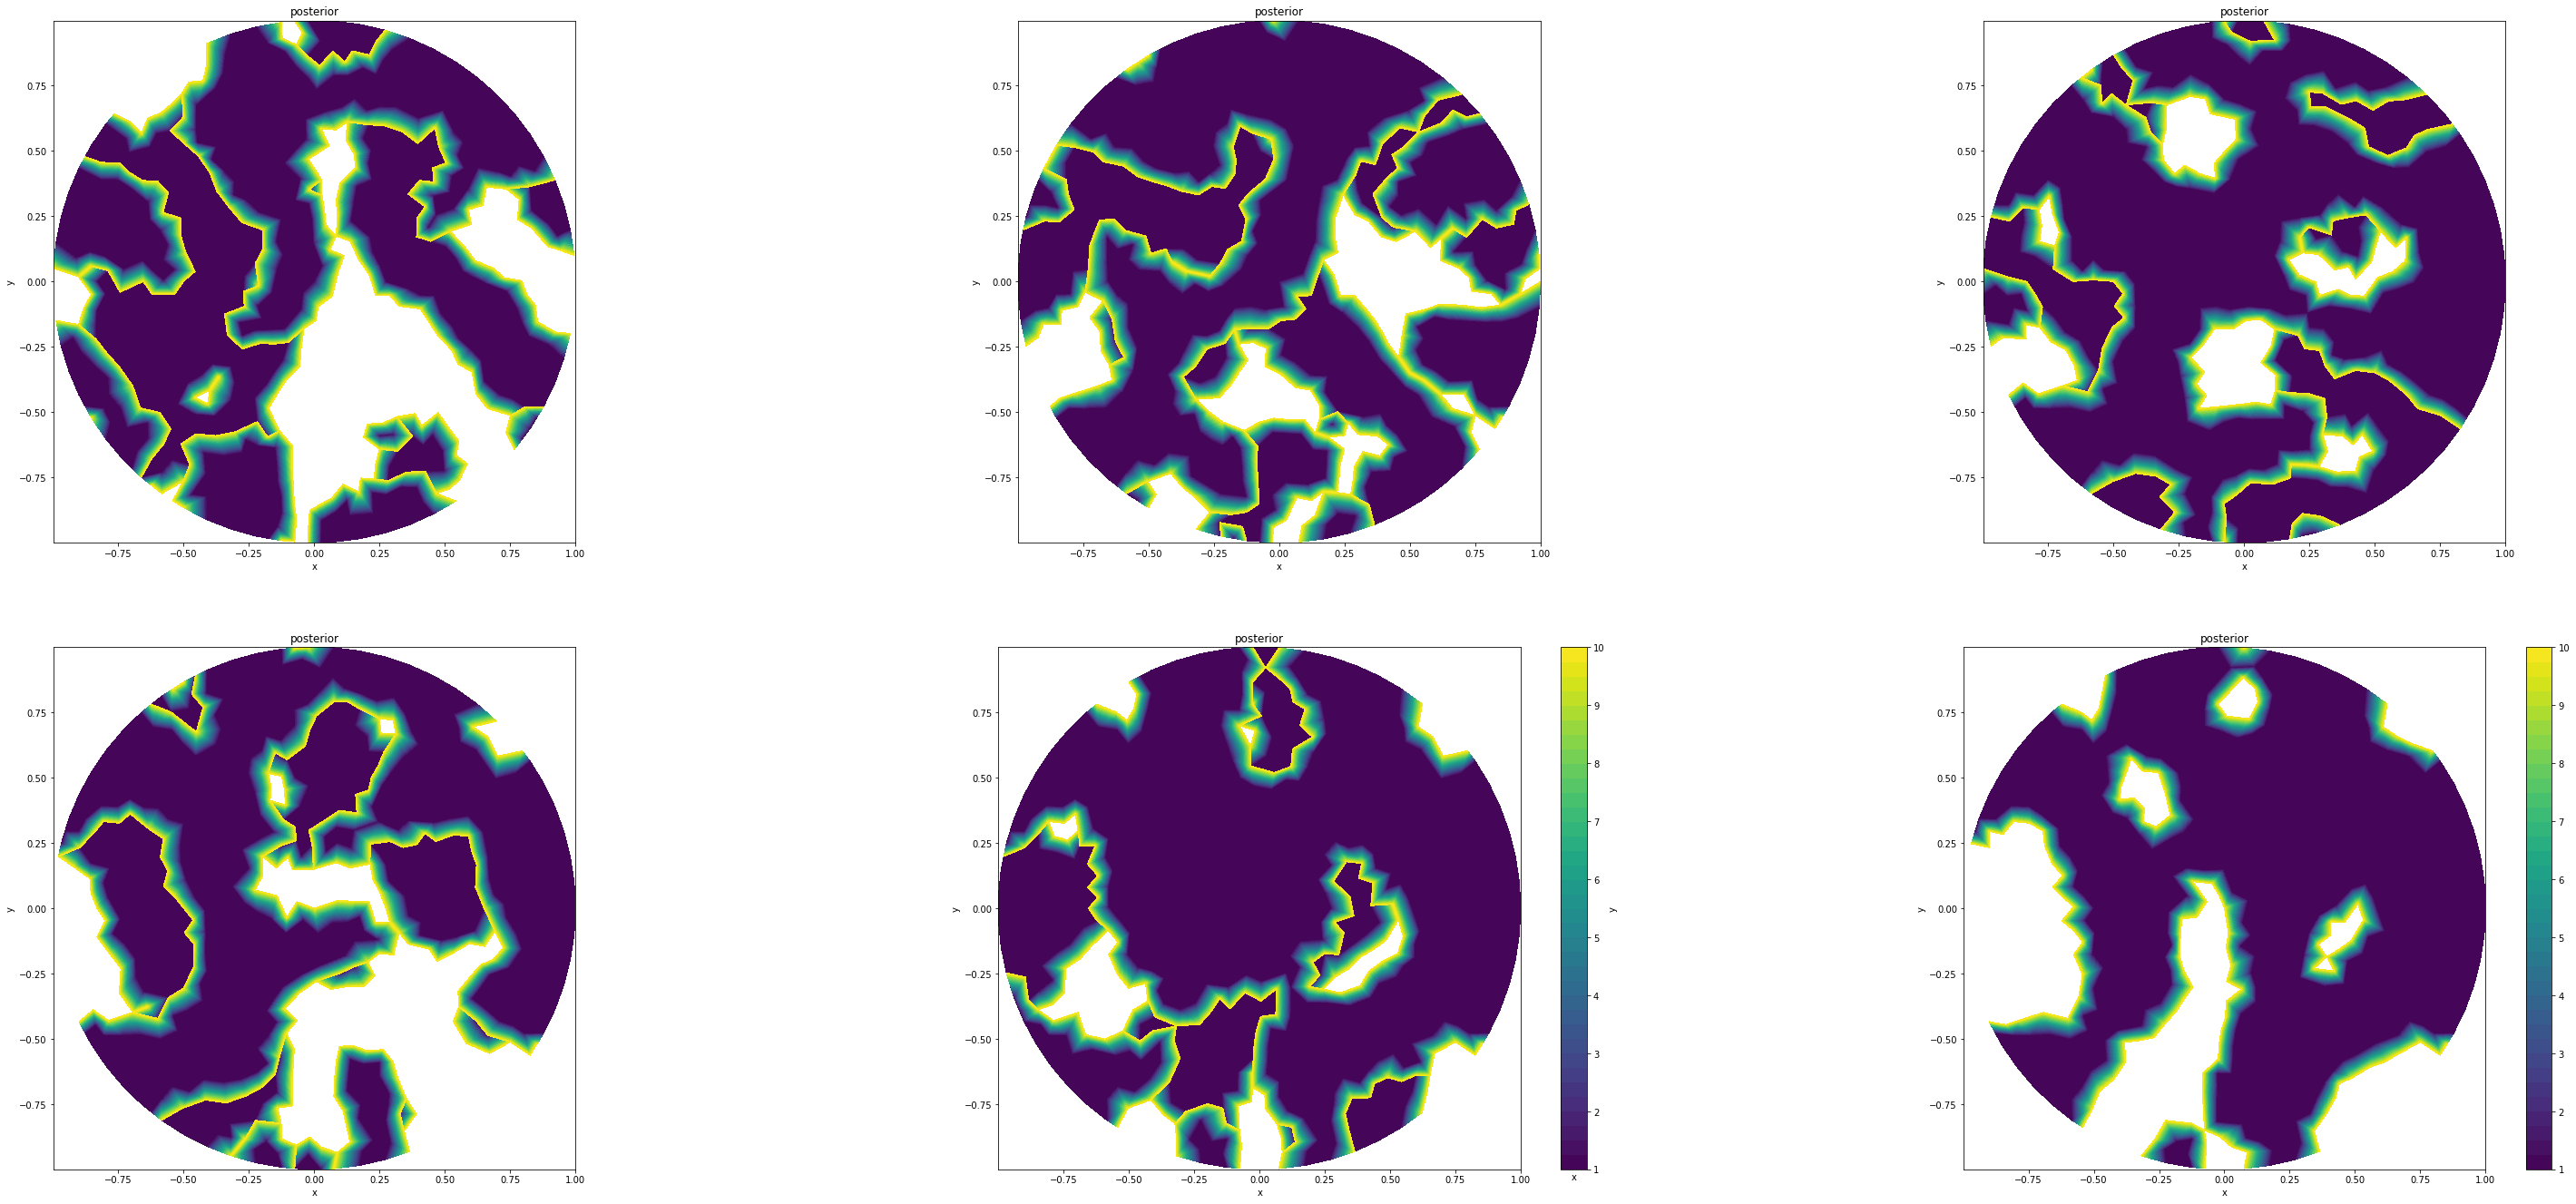

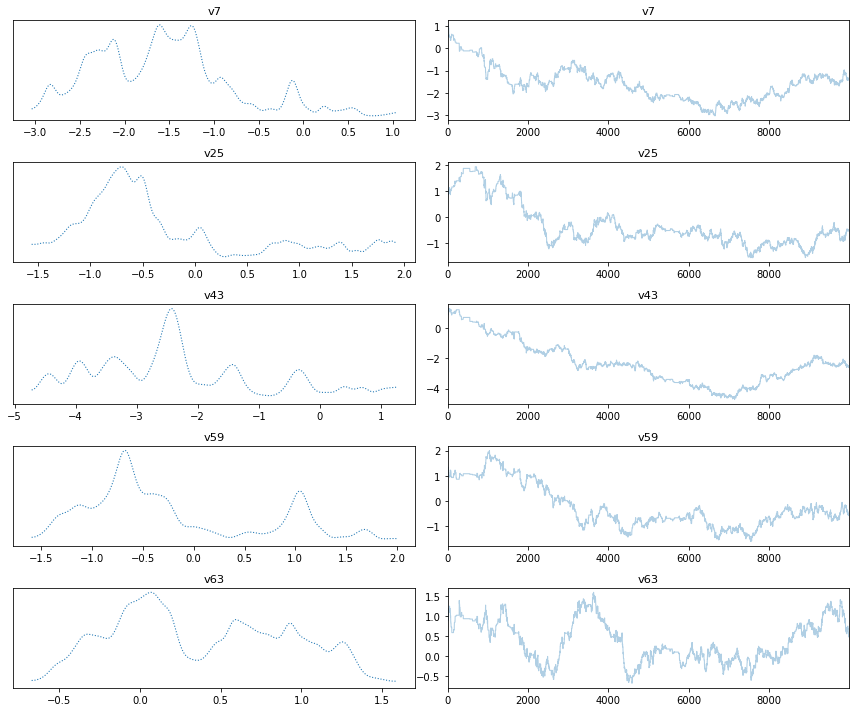

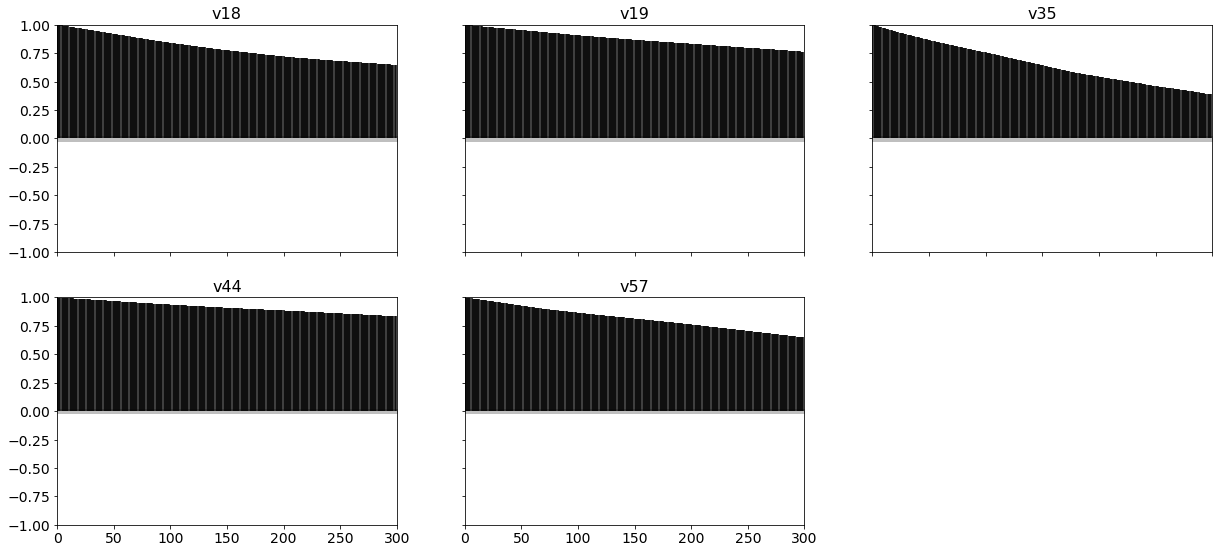

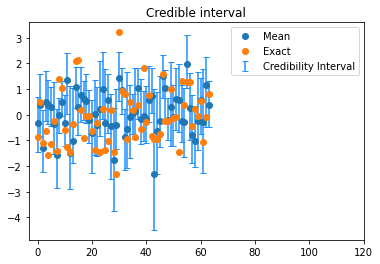

In [12]:
#%% 3 Third, we define a pCN sampler, sample, and inspect the prior and the posterior samples. 

#%% 3.1 Plot the exact solution
exactSolution.plot()

#%% 3.2 Plot prior samples
prior_samples = prior.sample(5)
ims = prior_samples.plot(title="prior")
plt.colorbar(ims[-1])


#%% 3.3 Create pCN Sampler 
pCNSampler = cuqi.sampler.pCN(
    posterior,
    scale=None,
    x0=None,
)

#%% 3.4 Sample using the pCN sampler
samplespCN = pCNSampler.sample_adapt(10000)

#%% 3.5 Plot posterior pCN samples 
ims = samplespCN.plot([0, 1000, 3000, 6000, 8000, 9000],title="posterior")
plt.colorbar(ims[-1])

# %% 3.6 Plot trace and autocorrelation (pCN)
samplespCN.plot_trace()
samplespCN.plot_autocorrelation(max_lag=300)

#%% 3.7 Plot credible interval (pCN)
plt.figure()
samplespCN.plot_ci(plot_par = True, exact=exactSolution)
plt.xticks(range(128)[::20], range(128)[::20])
plt.title("Credible interval")
# %%